## Imports

In [1]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

## Definitions

In [ ]:
def make_light_curve(
        file_dir,
        filt='i',
        aperture_radius = 8,  # Radius of the aperture
        annulus_inner_radius = 22,  # Inner radius of the annulus
        annulus_outer_radius = 30,  # Outer radius of the annulus
        star_list = [(2524.1591, 1855.3702), (2350.4573, 1230.4712), (2597.4297, 1511.4885), (2781.4578, 1358.5997),(2931.032, 1968.4543)],
        display_apertures=False,
        ):
    
    # Find all FITS files in the directory
    image_files = glob.glob(file_dir + '/' + filt + '/' + '*.fts')

    # Read header and get target/WCS information from the first image
    header = fits.getheader(r"E:\MACRO\MCV\MCV Code\VV_Pup_RLMT_Feb_2025\i\maw_VV_Pup_g_240s_2025-02-21T04-21-00.fts")
    # header = fits.getheader(image_files[0])
    wcs = WCS(header)
    try:
            target_name = header['BLKNAME']
    except KeyError:
            target_name = header['OBJECT']
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg

    # Pull binning information from header and use to calculate gain
    # This is hardcoded for 2x2 binning
    rdnoise = 6.7
    egain = header['EGAIN']
    gain = 4*egain
    
    # Convert the star list from pixel coordinates to RA/Dec using WCS
    star_list_ra_dec = []
    for x, y in star_list:
        star_ra, star_dec = wcs.all_pix2world(x, y, 0)
        star_list_ra_dec.append((star_ra, star_dec))

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:

        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        print('Processing', image_file)

        # Get the WCS information from the header
        wcs = WCS(header)

        # Get the pixel coordinates of the target star in each image
        xst, yst = wcs.all_world2pix(ra, dec,0)
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)]
        
        # Find the star coordinates in each image
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list.append((x_star, y_star))

        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for the image
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):

            # Create the aperture and annulus objects using the star coordinates
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)

            # Calculate the stats for the aperture and annulus and centroid
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)
            x, y = ap_stats.centroid

            # Create new aperture and annulus objects with the calculated centroid
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            # Subtract pedestal from the background mean and multiply by the area of the annulus to get the total background
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Error calculation (Poisson noise + background noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + (aperture.area/annulus_aperture.area)*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Optionally, display the image with the apertures and annuli
    if display_apertures:
        for image_file in image_files:

            # Load the FITS data
            data = fits.getdata(image_file)
            header = fits.getheader(image_file)
            wcs = WCS(header)
            _, median, std = sigma_clipped_stats(data, sigma=3.0)

            plt.imshow(data, vmin=median-3*std, vmax=median+3*std, cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

    # Calculate the total flux of the reference stars
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux'] 
    
    # Calculate the relative flux of the target star from the total flux of the reference stars
    results_df['rel_flux']=results_df['star_0_flux']/results_df['total_flux']

    # Calculate the percentage of flux for each star
    num_stars = len(star_list)
    for i in range(1, num_stars):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # Calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    # calculate the error on the relative flux
    results_df['star_0_relerror'] = (results_df['star_0_flux']/results_df['total_flux'])*(np.sqrt((results_df['star_0_error']/results_df['star_0_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux and error by the mean relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['rel_flux'], sigma=  2.0)
    results_df['norm_rel_flux'] = results_df['rel_flux']/mean_rel_flux
    results_df['norm_rel_flux_error'] = results_df['star_0_relerror']/mean_rel_flux

    # Save the results to a CSV file
    results_df.to_csv(file_dir + r'\Results_' + filt + '.csv', index=False)

    # Plot the relative flux
    plt.errorbar(results_df['Julian_Date'], results_df['rel_flux'], yerr=abs(results_df['star_0_relerror']), fmt='o')
    plt.xlabel('Julian Date')
    plt.ylabel('Relative Flux')
    plt.show()

## Running Function

Target Name: VV Pup
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T02-47-07.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T02-55-27.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T03-12-08.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T03-20-28.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T03-28-49.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T03-37-09.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T03-53-50.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T04-02-11.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T04-10-31.fts
Processing E:\MACRO\MCV\Images\VV Pup\2025-04-16/i\maw_VV_Pup_i_240s_2025-04-16T04-27-12.fts


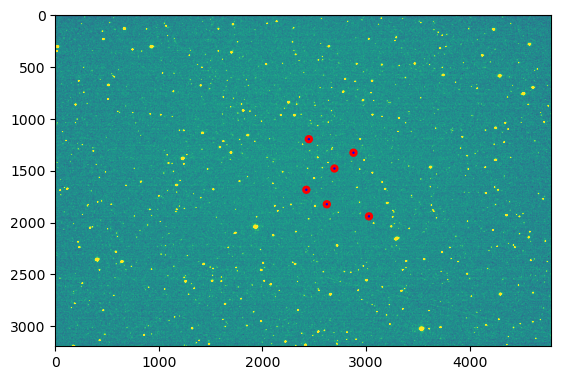

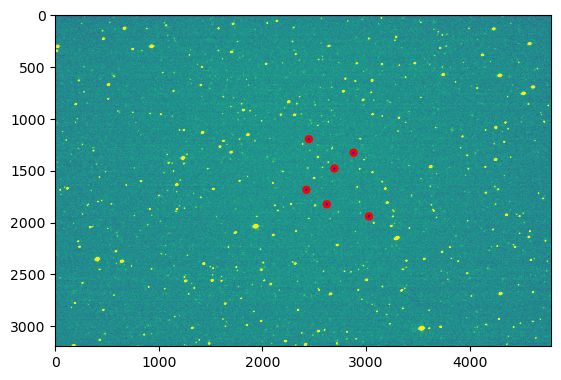

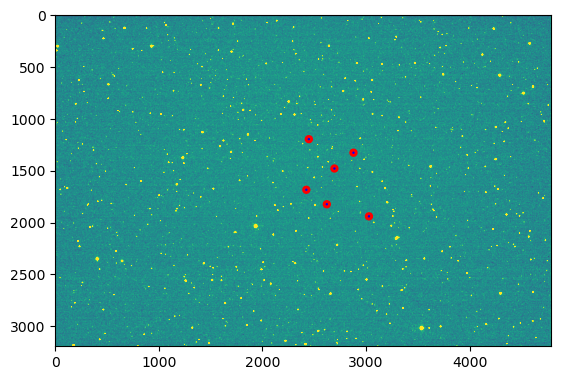

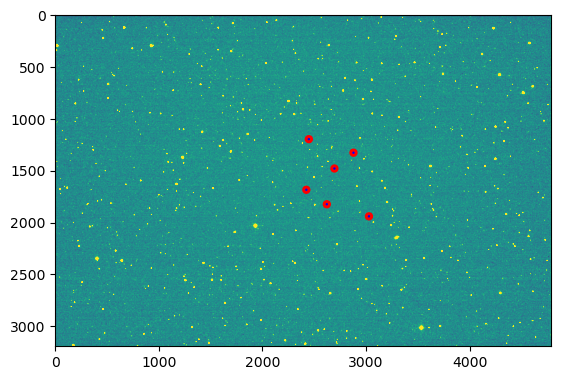

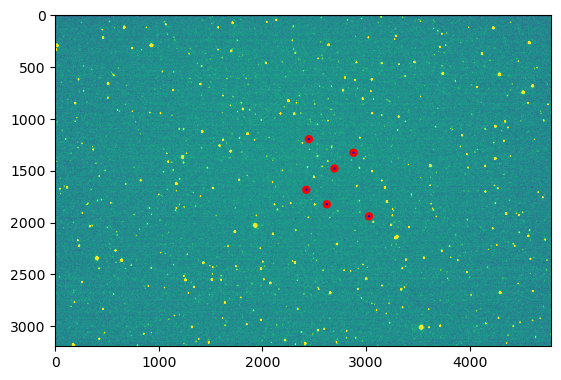

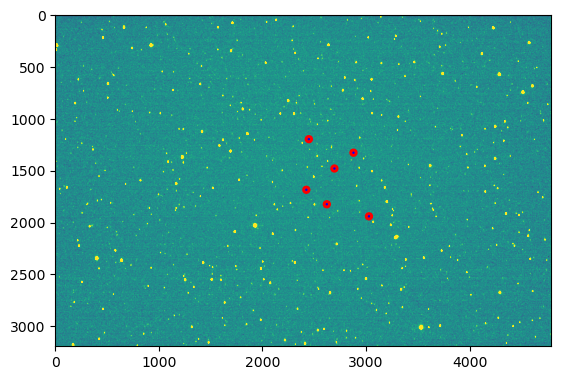

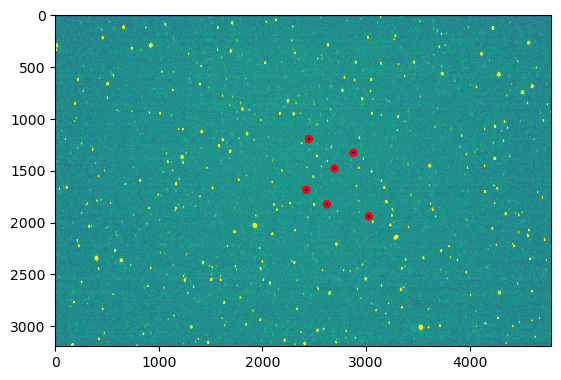

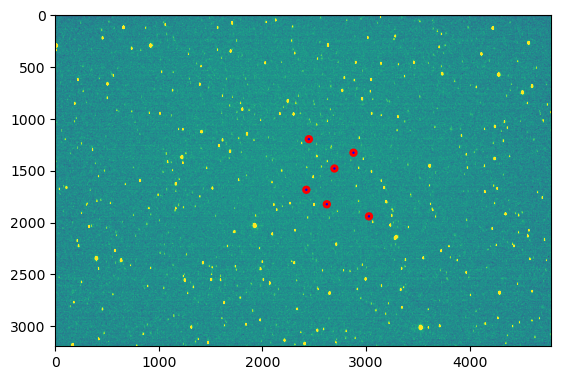

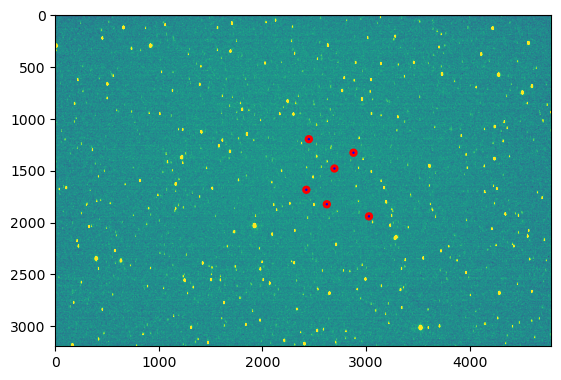

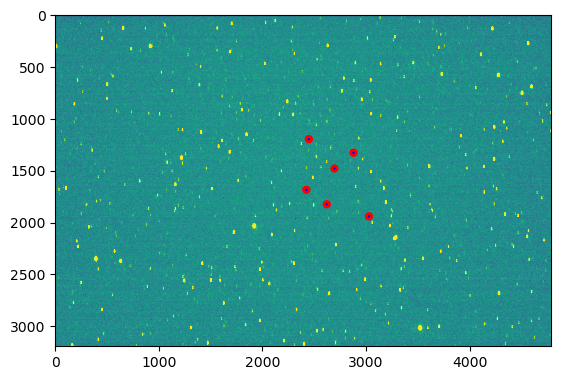

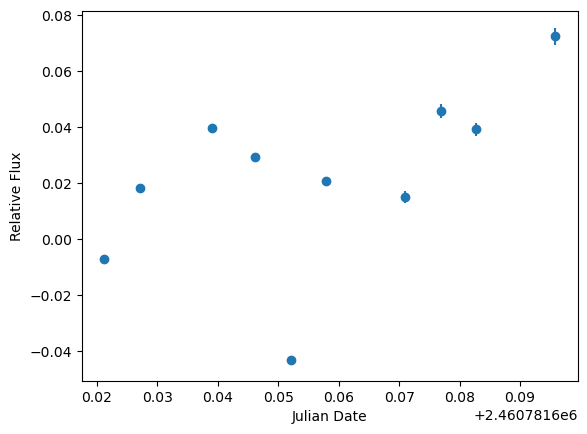

In [20]:
file_dir = r"E:\MACRO\MCV\Images\VV Pup\2025-04-16"
make_light_curve(file_dir, filt='i', display_apertures=True)


## Other: I haven't edited these yet, may not need

In [4]:
lc_g = pd.read_csv(file_dir + r'\Results_g.csv')
lc_r = pd.read_csv(file_dir + r'\Results_r.csv')
# lc_i = pd.read_csv(file_dir + r'\Results_i.csv')


#sort the dataframes by Julian Date
lc_g = lc_g.sort_values(by=['Julian_Date'])
lc_r = lc_r.sort_values(by=['Julian_Date'])
# lc_i = lc_i.sort_values(by=['Julian_Date'])

# t_start = Time('2025-02-21T04:10:00', scale='utc')
t_start = Time('2025-04-16T04:10:00', scale='utc')
# Get the Julian Date
jd_start = t_start.jd

t_end = Time('2025-04-16T07:10:00', scale='utc')
jd_end = t_end.jd


plt.errorbar(lc_g['Julian_Date'], lc_g['norm_rel_flux'], yerr=abs(lc_g['norm_rel_flux_error']), fmt='o', label='g', color='green')
plt.plot(lc_g['Julian_Date'], lc_g['norm_rel_flux'], color='green')    
plt.errorbar(lc_r['Julian_Date'], lc_r['norm_rel_flux'], yerr=abs(lc_r['norm_rel_flux_error']), fmt='o', label='r', color='red')
plt.plot(lc_r['Julian_Date'], lc_r['norm_rel_flux'], color='red')
# plt.errorbar(lc_i['Julian_Date'], lc_i['norm_rel_flux'], yerr=abs(lc_i['norm_rel_flux_error']), fmt='o', label='i', color='purple')
# plt.plot(lc_i['Julian_Date'], lc_i['norm_rel_flux'], color='purple')
# plt.axvline(jd_start, color='black', linestyle='--')
# plt.axvline(jd_end, color='black', linestyle='--')
# make light blue between the black lines
# plt.fill_between([jd_start, jd_end], 0.6, 1.4, color='lightblue', alpha=0.5)

'''plt.scatter(lc_g['Julian_Date'], lc_g['star_0_relflux']/np.mean(lc_g['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_1_relflux']/np.mean(lc_g['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_2_relflux']/np.mean(lc_g['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_3_relflux']/np.mean(lc_g['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_g['Julian_Date'], lc_g['star_4_relflux']/np.mean(lc_g['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_0_relflux']/np.mean(lc_i['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_1_relflux']/np.mean(lc_i['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_2_relflux']/np.mean(lc_i['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_3_relflux']/np.mean(lc_i['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_i['Julian_Date'], lc_i['star_4_relflux']/np.mean(lc_i['star_4_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_0_relflux']/np.mean(lc_r['star_0_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_1_relflux']/np.mean(lc_r['star_1_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_2_relflux']/np.mean(lc_r['star_2_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_3_relflux']/np.mean(lc_r['star_3_relflux']), alpha=0.5, color='gray')
plt.scatter(lc_r['Julian_Date'], lc_r['star_4_relflux']/np.mean(lc_r['star_4_relflux']), alpha=0.5, color='gray')'''



plt.title('VV Pup Light Curve ')
plt.xlabel('Julian Date')
plt.ylabel('Relative Flux')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\MACRO\\MCV\\Images\\VV Pup\\2025-04-16\\Results_g.csv'